# Import Library

In [24]:
from selenium import webdriver

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family=font_name)
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings(action="ignore")

import urllib.request as req
from urllib.request import urlopen
from urllib.request import HTTPError, URLError
import urllib.parse
from bs4 import BeautifulSoup
import requests

from tqdm import tqdm_notebook
import time

import re

# 1. 데이터 파악 및 EDA
- 전처리는 1월 5일까지 (가능하면 R로 독립(원인)변수들이 통계적으로 의미있는지 파악하는 것까지)
- 결과 변수 : 중식계, 석식계
- 원인 변수 : 일자, 요일, 본사정원수, 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수, 재택근무자수, 메뉴
- 파생 원인 변수 : 일자 -> 계절, 연도, 날씨(날씨 데이터 받아오기) // 인기메뉴 // 메뉴 카테고리화(어떻게 해야할지 고민해보기) // 실제 상주인원 계산 // 신메뉴 여부 // 명절 전날
- 전처리 : 메뉴, 요일 one-hot encoding // 일자 : datetype으로 // 값들이 다 이산변수이므로 int64가 적합. 다 바꿔주자 // 결측치 확인해보기. '0'으로 표시되어있는지 확인

In [124]:
data = pd.read_csv("C:/Users/tagos71/Desktop/Driver/Team3/data/train.csv", index_col = "일자")
data

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
일자,,,,,,,,,,,
2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0
2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0
2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0


In [87]:
test = pd.read_csv("C:/Users/tagos71/Desktop/Driver/Team3/data/test.csv", index_col = "일자")
test

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
일자,,,,,,,,,
2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
2021-02-01,월,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
2021-02-02,화,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치
2021-02-03,수,2924,59,199,5,286.0,모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치
2021-02-04,목,2924,61,211,476,288.0,모닝롤/사과파이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 아욱국 새송이버섯곤약장...,쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치
2021-02-05,금,2924,169,252,0,256.0,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치
2021-02-08,월,2924,88,174,690,329.0,모닝롤/스콘 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 근대나물무침 연두부...,쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1205 entries, 2016-02-01 to 2021-01-26
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   요일              1205 non-null   object 
 1   본사정원수           1205 non-null   int64  
 2   본사휴가자수          1205 non-null   int64  
 3   본사출장자수          1205 non-null   int64  
 4   본사시간외근무명령서승인건수  1205 non-null   int64  
 5   현본사소속재택근무자수     1205 non-null   float64
 6   조식메뉴            1205 non-null   object 
 7   중식메뉴            1205 non-null   object 
 8   석식메뉴            1205 non-null   object 
 9   중식계             1205 non-null   float64
 10  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 113.0+ KB


In [19]:
# 해당 데이터 소스의 게시판에 의하면 2018년 6월 1일 요일이 잘못되었음을 확인
data["요일"]["2018-05-20" : "2018-06-10"]
# 18년 6월 1일, 월요일에서 금요일로 바꿔야함

일자
2018-05-21    월
2018-05-23    수
2018-05-24    목
2018-05-25    금
2018-05-28    월
2018-05-29    화
2018-05-30    수
2018-05-31    목
2018-06-01    월
2018-06-04    월
2018-06-05    화
2018-06-07    목
2018-06-08    금
Name: 요일, dtype: object

In [20]:
data["요일"]["2018-06-01"] = "금"

<ipython-input-20-b1b3cdbb111b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["요일"]["2018-06-01"] = "금"


In [21]:
# 다시 확인
data["요일"]["2018-05-20" : "2018-06-10"]
# 제대로 바뀌었음

일자
2018-05-21    월
2018-05-23    수
2018-05-24    목
2018-05-25    금
2018-05-28    월
2018-05-29    화
2018-05-30    수
2018-05-31    목
2018-06-01    금
2018-06-04    월
2018-06-05    화
2018-06-07    목
2018-06-08    금
Name: 요일, dtype: object

In [22]:
data.describe()
# 25% ~ 75% 까지의 차가 표준편차보다 급격히 작음.
# 전형적인 표준편차 형태를 보일 것으로 예상

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000


Text(0, 0.5, 'frequency')

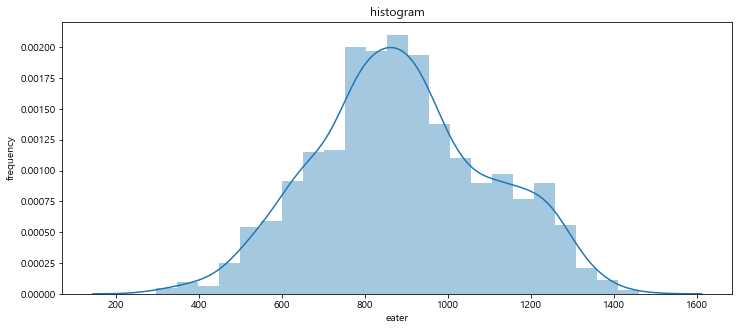

In [25]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)

ax = sns.distplot(data['중식계'])
ax.set_title("histogram")
ax.set_xlabel("eater")
ax.set_ylabel("frequency")

Text(0, 0.5, 'frequency')

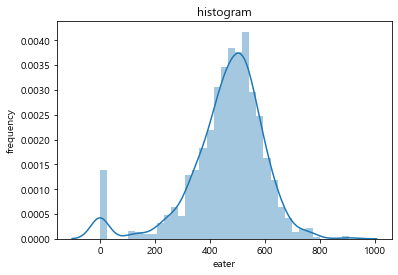

In [26]:
ax = sns.distplot(data['석식계'])
ax.set_title("histogram")
ax.set_xlabel("eater")
ax.set_ylabel("frequency")

In [29]:
### 0?
data[data['석식계'] == 0]

# 주로 석식을 운영하지 않은 날이나, 2017년 9월 27일과 2018년 2월 4일은 석식 운영했음에도 0으로 처리되어있음
# 석식계 분석시엔 해당 내용들은 제거 후 분석해줘야 더 정확한 분석이 가능할 것으로 예상

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
일자,,,,,,,,,,,
2016-11-30,수,2689,68,207,0,0.0,모닝롤/카스텔라 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개 ...,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,1109.0,0.0
2016-12-28,수,2705,166,225,0,0.0,모닝롤/고구마파이 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 북어계란국 ...,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,*,767.0,0.0
2017-01-25,수,2697,79,203,0,0.0,모닝롤/토마토샌드 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 ...,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,*,720.0,0.0
2017-02-22,수,2632,75,252,0,0.0,모닝롤/브라우니 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 꽃게탕 명엽채...,나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 ...,*,1065.0,0.0
2017-03-22,수,2627,53,235,0,0.0,모닝롤/찐빵 우유/주스 계란후라이 김치죽/쌀밥 (쌀:국내산) 콩나물국 김실파무침...,쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (...,*,953.0,0.0
2017-04-26,수,2626,45,304,0,0.0,모닝롤/와플 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 된장찌개 검정콩조...,비빔밥 (쌀:국내산) 맑은국 오징어튀김 견과류조림 하와이안샐러드 깍두기 (김...,*,835.0,0.0
2017-05-31,수,2637,43,265,0,0.0,모닝롤/베이글 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 자...,열무보리비빔밥 (쌀:국내산) 가쯔오장국 탕수만두 콥샐러드 오이지무침 포기김치...,자기계발의날,910.0,0.0
2017-06-28,수,2648,58,259,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 쇠고기매운국 고...,콩나물밥 (쌀:국내산) 얼갈이된장국 삼치구이 잡채 아삭고추무침 깍두기 (김치...,*자기계발의날*,745.0,0.0
2017-07-26,수,2839,254,246,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 민물새우찌개 숙...,나물비빔밥 미소장국 파스타샐러드 소세지오븐구이 오렌지 포기김치 (김치:국내산),가정의날,797.0,0.0


<AxesSubplot:xlabel='요일', ylabel='중식계'>

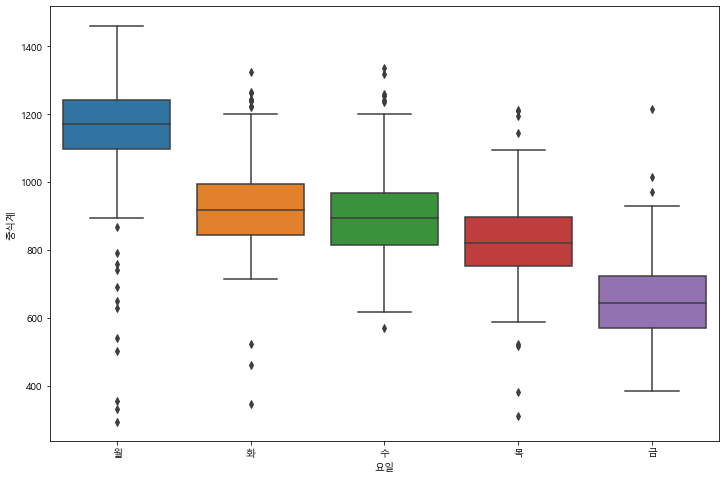

In [30]:
#### 요일별 중식계, 석식계
#### 평균적으로 월요일에 가장 많이 찾아오지만, 항상 그렇지 않다. 오차범위 밖에 최소값들이 많이 있음을 알 수 있다.
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 8)
sns.boxplot(x='요일', y='중식계', data=data)

<AxesSubplot:xlabel='요일', ylabel='석식계'>

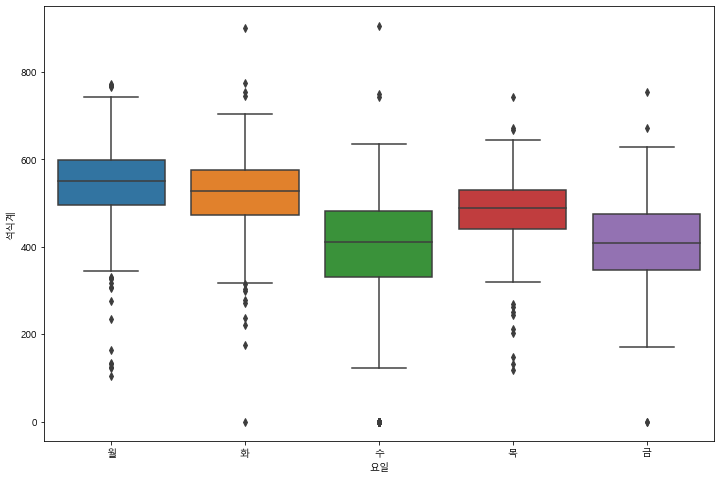

In [31]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 8)

sns.boxplot(x='요일', y='석식계', data=data)

In [42]:
#2020-3-20부터 코로나19로 인한 재택근무 활성화, 폭증한 것을 확인할 수 있음
data.loc["2020-03-01":, :"현본사소속재택근무자수"].head(20)

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
일자,,,,,,
2020-03-02,월,2950,108,133,786,14.0
2020-03-03,화,2950,76,185,753,12.0
2020-03-04,수,2950,74,205,1,19.0
2020-03-05,목,2950,84,232,612,15.0
2020-03-06,금,2950,166,251,0,12.0
2020-03-09,월,2950,91,129,784,16.0
2020-03-10,화,2950,67,168,678,20.0
2020-03-11,수,2950,74,197,0,23.0
2020-03-12,목,2950,78,243,555,17.0


<AxesSubplot:xlabel='현본사소속재택근무자수', ylabel='중식계'>

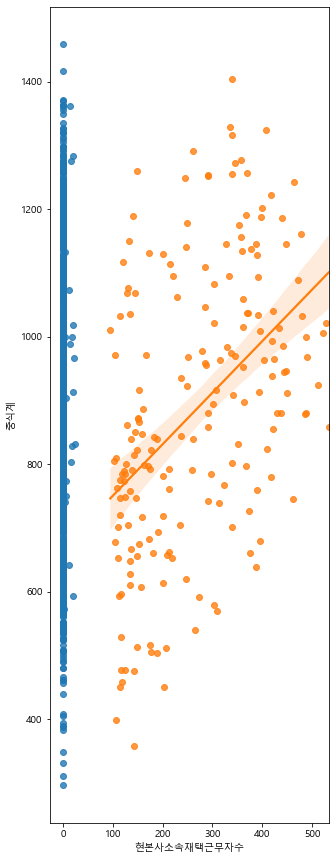

In [103]:
#코로나 이후, 재택근무자수와 중식계 관계. 뚜렷한 선형관계를 보이고 있진 않다. (많이 퍼져있음)
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(5, 15)


sns.regplot(x='현본사소속재택근무자수', y='중식계', data=data.iloc[:1010], fit_reg=False) # 재택근무 활성화 이전
sns.regplot(x='현본사소속재택근무자수', y='중식계', data=data.iloc[1010:], fit_reg=True) # 코로나로 인한 재택근무 활성화 이후

<AxesSubplot:xlabel='현본사소속재택근무자수', ylabel='석식계'>

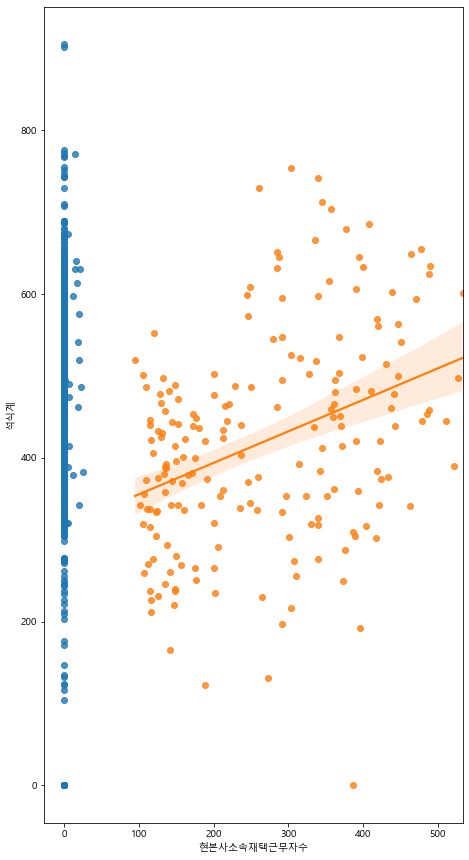

In [105]:
#코로나 이후, 재택근무자수와 석식계 관계. 마찬가지로 뚜렷한 선형관계를 보이고 있진 않다. (많이 퍼져있음)
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(7.5, 15)

sns.regplot(x='현본사소속재택근무자수', y='석식계', data=data.iloc[:1010], fit_reg=False) # 재택근무 활성화 이전
sns.regplot(x='현본사소속재택근무자수', y='석식계', data=data.iloc[1010:], fit_reg=True) # 코로나로 인한 재택근무 활성화 이후

In [95]:
# 사내 인원 관련 숫자와 중식계, 석식계의 관계를 상관관계로

# 1. 데이터 슬라이싱
data_a = data.loc[:, ['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식계', '석식계']]
data_a

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
0,2601,50,150,238,0,1039,331
1,2601,50,173,319,0,867,560
2,2601,56,180,111,0,1017,573
3,2601,104,220,355,0,978,525
4,2601,278,181,34,0,925,330
...,...,...,...,...,...,...,...
1200,2983,75,198,4,391,1093,421
1201,2983,92,231,462,351,832,353
1202,2983,255,248,1,303,579,217
1203,2983,107,153,616,327,1145,502


In [98]:
# 2. 휴가자, 출장자, 재택근무자 제외한 실제 본사 내 정원 파악해보기

data_a['실질정원수'] = data_a['본사정원수'] - (data_a['본사휴가자수'] + data_a['본사출장자수'] + data_a['현본사소속재택근무자수'])
# 3. 생성한 파생변수 위치 변경
data_a = data_a.loc[:, ['중식계', '석식계', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

# int로 변경
data_a = data_a.astype(np.int64)
data_a

,중식계,석식계,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,1039,331,2601,2401,50,150,238,0
1,867,560,2601,2378,50,173,319,0
2,1017,573,2601,2365,56,180,111,0
3,978,525,2601,2277,104,220,355,0
4,925,330,2601,2142,278,181,34,0
...,...,...,...,...,...,...,...,...
1200,1093,421,2983,2319,75,198,4,391
1201,832,353,2983,2309,92,231,462,351
1202,579,217,2983,2177,255,248,1,303
1203,1145,502,2983,2396,107,153,616,327


In [99]:
data_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   중식계             1205 non-null   int64
 1   석식계             1205 non-null   int64
 2   본사정원수           1205 non-null   int64
 3   실질정원수           1205 non-null   int64
 4   본사휴가자수          1205 non-null   int64
 5   본사출장자수          1205 non-null   int64
 6   본사시간외근무명령서승인건수  1205 non-null   int64
 7   현본사소속재택근무자수     1205 non-null   int64
dtypes: int64(8)
memory usage: 75.4 KB


<AxesSubplot:>

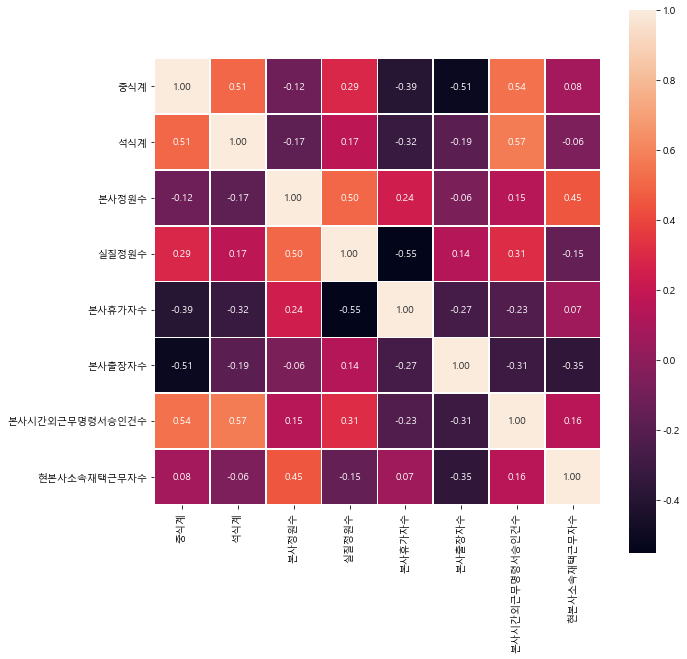

In [106]:
cols = ['중식계', '석식계', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']

plt.figure(figsize=(10,10))

heat = np.corrcoef(data_a[cols].T)
sns.heatmap(heat, annot=True, yticklabels=cols, xticklabels=cols, fmt='.2f', linewidths=.5, square=True)

In [ ]:
 """
 중식계(점심)은 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수
 이 세 값이 상관관계가 큰 이유는 휴가자와 출장자는 근무지에 없어서!
 점심이 본사시간외근무명령서승인건수와 관련 있는 이유는 바쁘니까 야근하고 바쁘니까 밖에서 밥먹을 시간이 없는 것으로 이해
 """

<AxesSubplot:xlabel='본사시간외근무명령서승인건수', ylabel='중식계'>

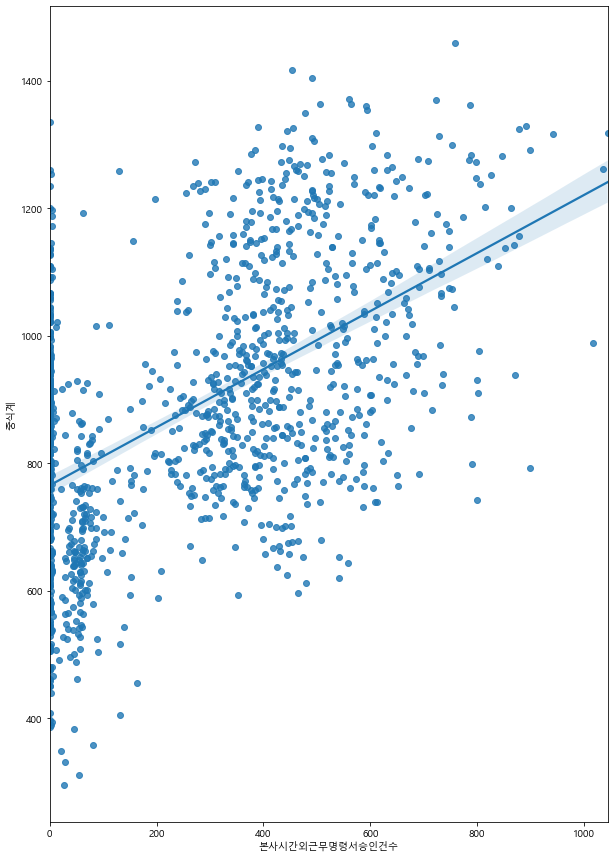

In [109]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(10, 15)

sns.regplot(x="본사시간외근무명령서승인건수", y='중식계', data=data_a)

<AxesSubplot:xlabel='본사시간외근무명령서승인건수', ylabel='석식계'>

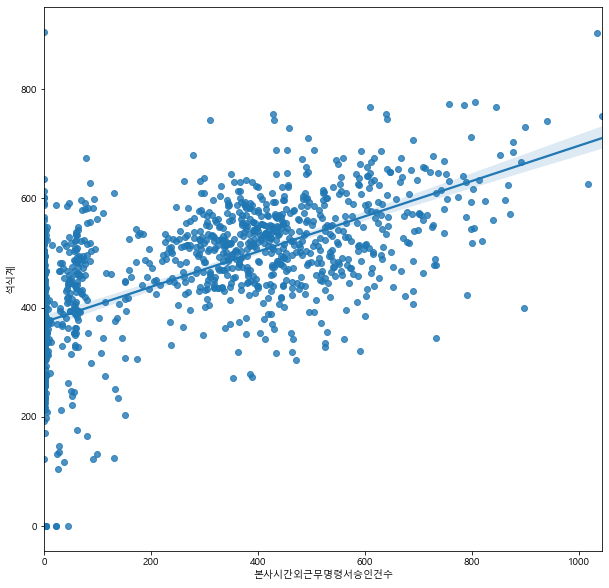

In [108]:
# 데이터가 선형관계에 있으나 근무명령승인건수에 관계없이 석식계, 중식계 발생하는 건수도 많음을 알 수 있음
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(10, 10)

sns.regplot(x="본사시간외근무명령서승인건수", y='석식계', data=data_a)

<AxesSubplot:xlabel='중식계', ylabel='석식계'>

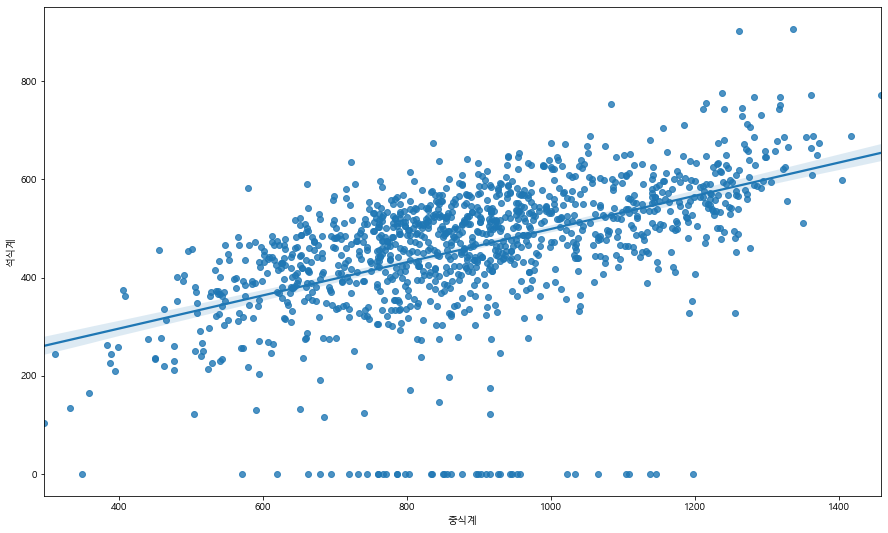

In [107]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(15, 9)

sns.regplot(x="중식계", y='석식계', data=data_a)
# 중식계가 많은 날, 석식계도 많다 :)
# 석식계를 예측할 땐, 중식계를 원인변수로 두는 것도 하나의 방법

# 2. 데이터 변경

## 1. 데이터 형태 변경
- 일자 -> 날짜 데이터 형태로
- 인원 수 -> int로 :: 해당 데이터 기준은 인원 수이고 사람은 정확히 끊어서 셀 수 있다.

In [67]:
data['일자'] = pd.to_datetime(data['일자'])
#df['Datetime'] = df['Datetime'].apply(lambda _: datetime.strptime(_,"%m/%d/%Y, %H:%M:%S"))
data

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0


In [69]:
data['현본사소속재택근무자수'] = data['현본사소속재택근무자수'].astype(np.int64)
data['중식계'] = data['중식계'].astype(np.int64)
data['석식계'] = data['석식계'].astype(np.int64)

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   실질정원수           1205 non-null   float64       
 4   본사휴가자수          1205 non-null   int64         
 5   본사출장자수          1205 non-null   int64         
 6   본사시간외근무명령서승인건수  1205 non-null   int64         
 7   현본사소속재택근무자수     1205 non-null   float64       
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(3)
memory usage: 113.1+ KB


In [119]:
### 시계열에 따른 변화량을 시각화.
### 1. date type을 인덱스로
data_timegraph = data.set_index('일자')
data_timegraph

,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계
일자,,,,,,,,,,,
2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331
2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560
2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573
2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525
2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421
2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353
2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217


<AxesSubplot:xlabel='일자'>

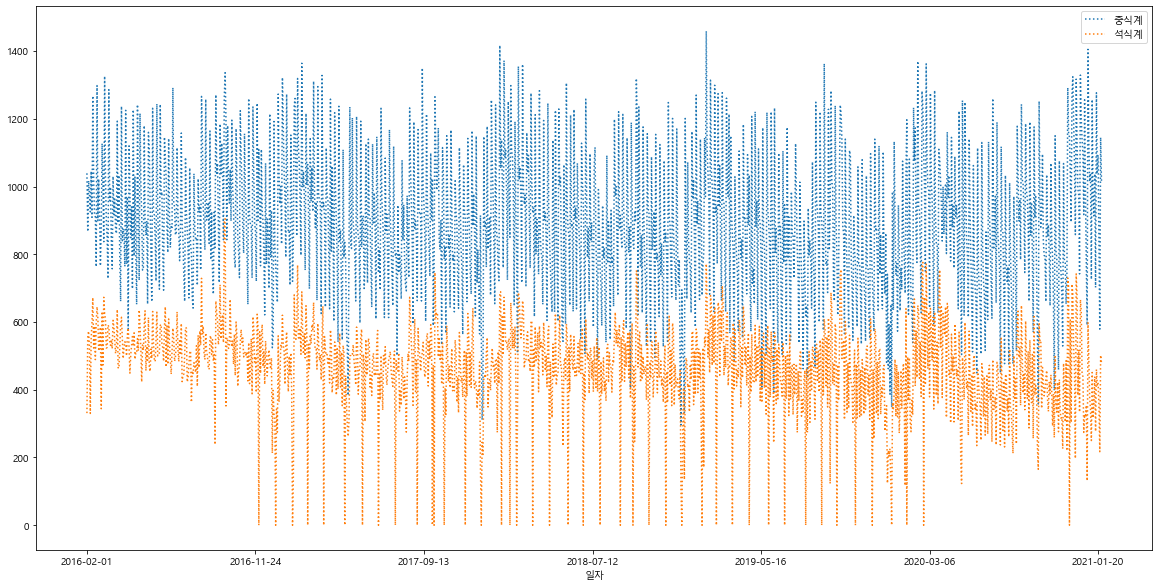

In [120]:
### 2. 중식계와 석식계 변화량 파악
### 매년, 계절별, 월별로 일정한 패턴을 보이는 듯함
### 중식계와 석식계는 비슷한 증감 패턴을 보인다
### 코로나 직후, 석식량은 오히려 코로나 전에 비해 늘어난 모습을 보인다.
graph = data_timegraph.loc[:, ['중식계', '석식계']]
graph.plot(figsize=(20,10), ls=':')

<AxesSubplot:xlabel='일자'>

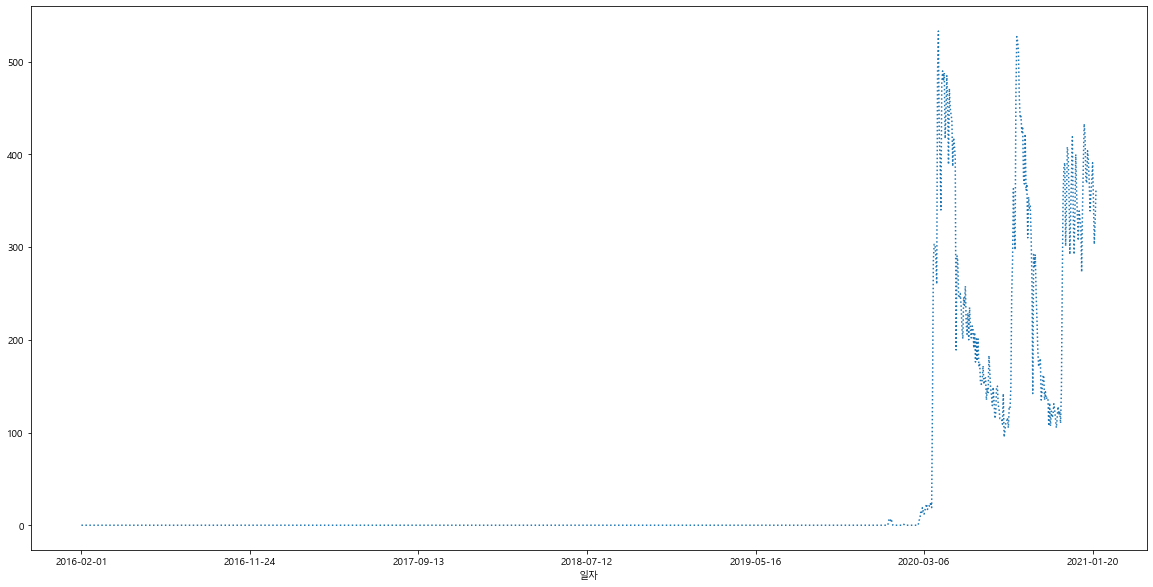

In [121]:
### 3. 재택근무자 수 변화량 파악
### 코로나 19 이 후 급격히 늘어나는 모습을 보임
graph = data_timegraph.loc[:, '현본사소속재택근무자수']
graph.plot(figsize=(20,10), ls=':')

<AxesSubplot:xlabel='일자'>

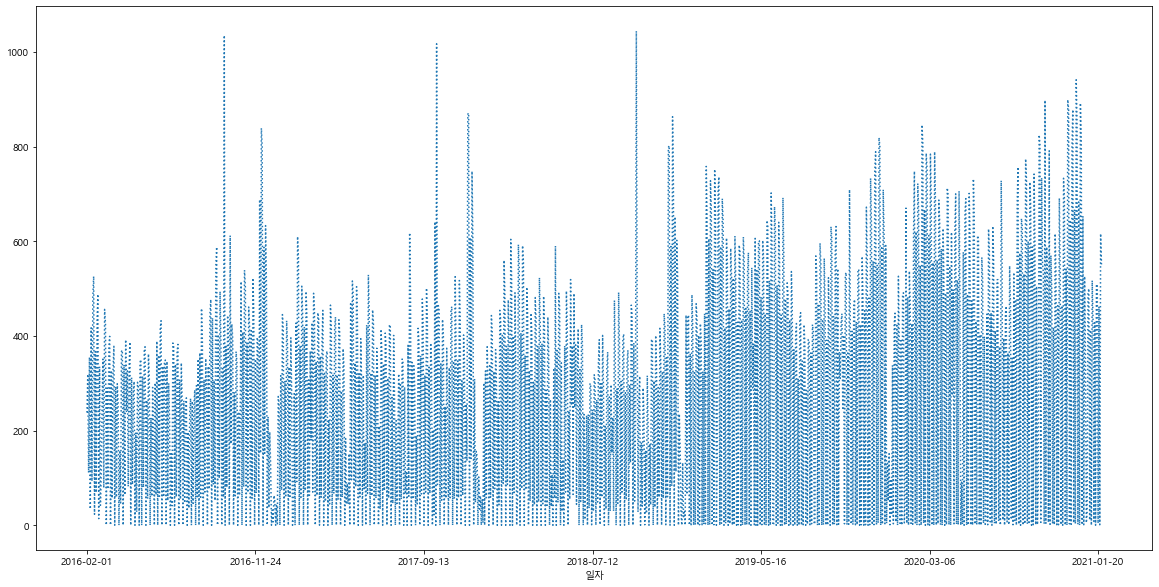

In [122]:
### 4. 야근자 수 변화량 파악
### 16년, 17년, 18년엔 특정 날짜에 시간외근무명령승인건수가 증가
### 다만, 19년과 20년도엔 이러한 패턴이 안보임.
### 이유를 찾고 21년도는 이를 기준으로 야근자 수가 늘어날지 안늘어날지 파악하는 것 필요해보임
graph = data_timegraph.loc[:, '본사시간외근무명령서승인건수']
graph.plot(figsize=(20,10), ls=':')

## 2. 근무자 관련 파생변수
- 사내 실 근무자 수 파악

In [127]:
data.head()
data=data.reset_index()

In [134]:
data['실질정원수'] = data['본사정원수'] - (data['본사휴가자수'] + data['본사출장자수'] + data['현본사소속재택근무자수'])

data = data.loc[:, ['일자', '요일', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식메뉴', '석식메뉴', '중식계', '석식계']]
data['일자'] = pd.to_datetime(data['일자'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   실질정원수           1205 non-null   float64       
 4   본사휴가자수          1205 non-null   int64         
 5   본사출장자수          1205 non-null   int64         
 6   본사시간외근무명령서승인건수  1205 non-null   int64         
 7   현본사소속재택근무자수     1205 non-null   float64       
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(3)
memory usage: 113.1+ KB


## 3. 일자에서 계절, 연도, 월, 날 뽑아내기

In [129]:
data['일자']

0       2016-02-01
1       2016-02-02
2       2016-02-03
3       2016-02-04
4       2016-02-05
           ...    
1200    2021-01-20
1201    2021-01-21
1202    2021-01-22
1203    2021-01-25
1204    2021-01-26
Name: 일자, Length: 1205, dtype: object

In [135]:
data['Month'] = data['일자'].dt.strftime('%m')
data['Date'] = data['일자'].dt.strftime('%d')
# data['Month'] = data['일자'].dt.month
# data['Date'] = data['일자'].dt.day

data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date
0,2016-02-01,월,2601,2401.0,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,02,01
1,2016-02-02,화,2601,2378.0,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,02,02
2,2016-02-03,수,2601,2365.0,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,02,03
3,2016-02-04,목,2601,2277.0,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,02,04
4,2016-02-05,금,2601,2142.0,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,02,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319.0,75,198,4,391.0,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0,01,20
1201,2021-01-21,목,2983,2309.0,92,231,462,351.0,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0,01,21
1202,2021-01-22,금,2983,2177.0,255,248,1,303.0,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0,01,22
1203,2021-01-25,월,2983,2396.0,107,153,616,327.0,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0,01,25


In [78]:
data['Month']

0       02
1       02
2       02
3       02
4       02
        ..
1200    01
1201    01
1202    01
1203    01
1204    01
Name: Month, Length: 1205, dtype: object

In [136]:
### 계절추가
season = []

for index in range(len(data)):
    if data['Month'][index] == '03' or data['Month'][index] == '04' or data['Month'][index] == '05':
        season.append('봄')
    elif data['Month'][index] == '06' or data['Month'][index] == '07' or data['Month'][index] == '08':
        season.append('여름')
    elif data['Month'][index] == '09' or data['Month'][index] == '10' or data['Month'][index] == '11':
        season.append('가을')
    elif data['Month'][index] == '12' or data['Month'][index] == '01' or data['Month'][index] == '02':
        season.append('겨울')

len(season)

1205

In [137]:
data['Season'] = season
data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season
0,2016-02-01,월,2601,2401.0,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,02,01,겨울
1,2016-02-02,화,2601,2378.0,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,02,02,겨울
2,2016-02-03,수,2601,2365.0,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,02,03,겨울
3,2016-02-04,목,2601,2277.0,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,02,04,겨울
4,2016-02-05,금,2601,2142.0,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,02,05,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319.0,75,198,4,391.0,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0,01,20,겨울
1201,2021-01-21,목,2983,2309.0,92,231,462,351.0,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0,01,21,겨울
1202,2021-01-22,금,2983,2177.0,255,248,1,303.0,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0,01,22,겨울
1203,2021-01-25,월,2983,2396.0,107,153,616,327.0,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0,01,25,겨울


# Checkpoint(2022.01.04 5pm)
- 데이터 타입 변경 / 실제 사내 근무자 수 파악 / 계절 변수 추가

In [138]:
data.to_csv("C:/Users/tagos71/Desktop/Driver/Team3/data/20220104train.csv", encoding='utf-8', index=False)

## 4. 메뉴
- 조식메뉴제거(앞에서 이미 제거 했음)
- 신메뉴 출시 카테고리 만들어주기
- 중식, 석식 메뉴에서 주요 메뉴 뽑아내기
- 메뉴 카테고리화 밥 or 특별식 밥 // 메인메뉴 // 국
- 중식, 석식 신메뉴 Yes or No 칼럼 만들기


In [139]:
data = pd.read_csv("C:/Users/tagos71/Desktop/Driver/Team3/data/20220104train.csv")
data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season
0,2016-02-01,월,2601,2401.0,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2,1,겨울
1,2016-02-02,화,2601,2378.0,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2,2,겨울
2,2016-02-03,수,2601,2365.0,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2,3,겨울
3,2016-02-04,목,2601,2277.0,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2,4,겨울
4,2016-02-05,금,2601,2142.0,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2,5,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319.0,75,198,4,391.0,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0,1,20,겨울
1201,2021-01-21,목,2983,2309.0,92,231,462,351.0,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0,1,21,겨울
1202,2021-01-22,금,2983,2177.0,255,248,1,303.0,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0,1,22,겨울
1203,2021-01-25,월,2983,2396.0,107,153,616,327.0,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0,1,25,겨울


In [140]:
#밥
print(data['중식메뉴'][0].split(' ')[0])
#국
print(data['중식메뉴'][0].split(' ')[2])
#메인반찬
print(data['중식메뉴'][0].split(' ')[4])

### 밥이 메인이면?
#밥
print(data['중식메뉴'][2].split(' ')[0])
#국
print(data['중식메뉴'][2].split(' ')[2])
#메인반찬
print(data['중식메뉴'][2].split(' ')[4])


### 뒤엔 원산지가 없어서 순서가 다르다. 단순 반복문과 split으론 원하는 결과물 얻을 수 없다.
#밥
print(data['중식메뉴'][1202].split(' ')[0])
#국 #요거닭이 나와
print(data['중식메뉴'][1202].split(' ')[2])
#메인반찬
print(data['중식메뉴'][1202].split(' ')[4])

# 일관된 결과물 얻으려면 원산지 정보를 제거해줘야한다.
# split으로 나누고 반복문과 조건문으로 ()가 있으면 제거하라는 명령어 통해 원산지 정보만 없앨 수 있다.

쌀밥/잡곡밥
오징어찌개
쇠불고기
카레덮밥
팽이장국
치킨핑거
전주비빔밥*약고추장
요거닭
파프리카해초무침


In [204]:
'New' in data['석식메뉴'][1204]

True

In [205]:
New_lunch = []
New_dinner = []

for index in range(len(data)):
    if 'New' in data['중식메뉴'][index]:
        New_lunch.append('Y')
    else:
        New_lunch.append('N')

for index in range(len(data)):
    if 'New' in data['석식메뉴'][index]:
        New_dinner.append('Y')
    else:
        New_dinner.append('N')

print(len(New_lunch))
print(len(New_dinner))

1205
1205


In [206]:
data['New_lunch'] = New_lunch
data['New_dinner'] = New_dinner

data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season,New_lunch,New_dinner
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2,1,겨울,N,N
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2,2,겨울,N,N
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2,3,겨울,N,N
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2,4,겨울,N,N
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2,5,겨울,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421,1,20,겨울,N,N
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353,1,21,겨울,N,N
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217,1,22,겨울,N,N
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502,1,25,겨울,N,N


## checkpoint(2021.01.03 16pm)
- 신메뉴 칼럼 생성

In [207]:
data.to_csv("data/20210103.csv", encoding='utf-8', index=False)

In [208]:
data = pd.read_csv("data/20210103.csv")

### 1. 중식

In [51]:
# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch = []

for index in range(len(data)):
    tmp = data.loc[index,'중식메뉴'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    # ()안에 있는 내용 제거
    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch.append(tmp) 

In [52]:
for index in range(len(data)): # 밥은 큰 차이가 없을것같으므로 쌀밥은 다 밥으로 통일
    if '쌀밥' in lunch[index][0]:
        lunch[index][0] = '밥'

In [53]:
lunch[:3]

[['밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치']]

In [54]:
# 밥, 국, 메인반찬1로 나누기
# 원핫 인코딩하면 너무 길어질 거 같은데.. 간단히 카테고리화할 방법 찾아야하나?
# 길이 신경 안써도 되나?
rice=[]
soup=[]
main=[]

for i in range(len(data)):
    if lunch[i][0]:
        rice.append(lunch[i][0])
    if lunch[i][1]:
        soup.append(lunch[i][1])
    if lunch[i][2]:
        main.append(lunch[i][2])

data['lunch_rice'] = rice
data['lunch_soup'] = soup
data['lunch_main'] = main

In [55]:
print(data['lunch_rice'].unique())

['밥' '카레덮밥' '낙지비빔밥' '비빔밥' '곤드레밥' '콩나물밥*달래장' '봄새싹비빔밥' '콩나물밥' '나물비빔밥'
 '단호박영양밥' '산채비빔밥' '낙지볶음밥' '열무비빔밥' '참치회덮밥' '연복풍덮밥' '열무보리비빔밥' '불고기덮밥'
 '산채비빔밥*강된장' '짜장밥' '버섯영양밥' '소불고기덮밥' '오곡밥' '곤드레밥*강된장' '봄나물비빔밥' '카레라이스'
 '짜장덮밥' '<초복특식>' '김치제육덮밥' '곤드레밥*간장양념' '단호박카레라이스' '곤드레밥*양념장' '삼계탕'
 '콩나물밥*양념장' '마파두부덮밥' '야채볶음밥*짜장소스' '김치볶음밥' '오므라이스' '김치볶음밥/계란' '파인애플볶음밥'
 '김치필라프' '불고기비빔밥' '김밥볶음밥' '고기듬뿍카레라이스' '건강비빔밥*약고추장' '새우날치알볶음밥' '소고기콩나물밥*양념'
 '닭살카레라이스' '열무보리비빔밥/강된장' '베이컨김치볶음밥' '돈육버섯고추장덮밥' '비빔밥*약고추장' '낙지비빔밥*계란후라이'
 '계란채소볶음밥' '전주비빔밥' '호박된장국' '전주비빔밥*약고추장']


In [56]:
data[data['lunch_rice'] == '<초복특식>']
#이거 어떻게 처리할까? 그냥 둘까?

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,lunch_rice,lunch_soup,lunch_main
356,2017-07-12,수,2839,2507,69,263,0,0,"<초복특식> 삼계탕 (닭:국내산) 찹쌀밥 (찹쌀,쌀:국내산) 생야채&쌈장 수박 ...",쌀밥/잡곡밥 (쌀:국내산) 해물된장찌개 모둠장조림 참치야채전 노각무침 포기김...,918,414,<초복특식>,삼계탕,찹쌀밥
840,2019-07-12,금,2760,2210,244,306,0,0,"<초복특식> 삼계탕 (닭:국내산) 찹쌀밥 (찹쌀,쌀:국내산) 생야채&쌈장 수박 ...",쌀밥/잡곡밥 (쌀:국내산) 된장찌개 소고기장조림 (쇠고기:호주산) 비엔나케찹볶음 ...,856,385,<초복특식>,삼계탕,찹쌀밥


In [58]:
data.head(20)

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,lunch_rice,lunch_soup,lunch_main
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,밥,오징어찌개,쇠불고기
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,밥,김치찌개,가자미튀김
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,카레덮밥,팽이장국,치킨핑거
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,밥,쇠고기무국,주꾸미볶음
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,밥,떡국,돈육씨앗강정
5,2016-02-11,목,2601,2075,383,143,417,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",1045,550,밥,시래기국,훈제오리구이
6,2016-02-12,금,2601,2056,389,156,93,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",909,598,밥,꽃게탕,돈육굴소스볶음
7,2016-02-15,월,2601,2310,87,204,482,0,쌀밥/잡곡밥 (쌀:국내산) 시금치국 닭감자조림 (닭고기:국내산) 연두부*양념장 ...,"쌀밥/잡곡밥 (쌀:국내산) 홍합미역국 등갈비김치찜 (돼지고기,김치:국내산) 임연수...",1268,672,밥,시금치국,닭감자조림
8,2016-02-16,화,2601,2293,72,236,526,0,쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 (쇠고기:호주산) 탕수어 (동태:러시아산) 오...,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 쇠불고기 (쇠고기:호주산) 해파리겨자채 봄동...,1014,523,밥,쇠고기무국,탕수어
9,2016-02-17,수,2601,2273,78,250,23,0,쌀밥/잡곡밥 (쌀:국내산) 냉이된장국 쇠고기장조림 (쇠고기:호주산) 통도라지구이 ...,볶음밥*자장소스 (쌀:국내산) 맑은국 새우또띠아 쨔샤이무침 요플레 포기김치 ...,916,588,밥,냉이된장국,쇠고기장조림


### 석식

In [59]:
dinner = []
index_list = []

for index in range(len(data)):
    tmp = data.loc[index,'석식메뉴'].split(' ')
    tmp = ' '.join(tmp).split()
    index_list.append(index)

    for menu_d in tmp:
        if '(' in menu_d:
            tmp.remove(menu_d)
    dinner.append(tmp)

In [60]:
print(len(data))
print(len(dinner))
print(len(lunch))


1205
1205
1205


In [64]:
for index in range(len(data)):
    if '쌀밥' in dinner[index][0]:
        dinner[index][0] = '밥'
    elif '흑미밥' in dinner[index][0]:
        dinner[index][0] = '밥'
    elif '*' in dinner[index]:
        dinner[index] = ['*','*','*']
    elif '자기계발의날' in dinner[index]:
        dinner[index] = ['*','*','*']
    elif '가정의날' in dinner[index]:
        dinner[index] = ['*','*','*']
    elif '자기개발의날' in dinner[index]:
        dinner[index] = ['*','*','*']

# *은 나중에 지워줄 것

IndexError: list index out of range

In [65]:
data[data['석식계'] == 0]['석식메뉴'].unique()

array(['    *        ', '     *       ', '      자기계발의날      ',
       '      *자기계발의날*      ', '      가정의날      ',
       '쌀밥/잡곡밥 (쌀:국내산) 된장찌개  미니함박조림  계란말이  비름나물  포기김치 (김치:국내산) ',
       '쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국  고추잡채*꽃빵  계란찜  오이무침  포기김치 (김치:국내산) ',
       '      *      ', '            ', '    자기계발의날        ',
       '    자기개발의날        ', '    *  자기계발의날  *    ',
       '    *  자기개발의날  *    ', '   *  자기개발의날  *     ',
       ' ＜자기 계발의 날＞      '], dtype=object)

In [66]:
dinner_rice=[]
dinner_soup=[]
dinner_main=[]

for i in range(len(data)):
    rice.append(dinner[i][0])
    soup.append(dinner[i][1])
    main.append(dinner[i][2])

IndexError: list index out of range

In [25]:
data['dinner_rice'] = dinner_rice
data['dinner_soup'] = dinner_soup
data['dinner_main'] = dinner_main

ValueError: Length of values (0) does not match length of index (1205)

In [26]:
data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,lunch_rice,lunch_soup,lunch_main
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,밥,오징어찌개,쇠불고기
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,밥,김치찌개,가자미튀김
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,카레덮밥,팽이장국,치킨핑거
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,밥,쇠고기무국,주꾸미볶음
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,밥,떡국,돈육씨앗강정
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421,밥,아욱국,수제함박스테이크
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353,밥,냉이된장국,동파육
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217,전주비빔밥*약고추장,계란파국,요거닭
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502,밥,전주식콩나물해장국,돈육간장불고기


## 4. 날씨

- data from : https://www.weather.go.kr/weather/climate/past_table.jsp?stn=108&x=11&y=9&yy=2016&obs=07

In [209]:
weather = pd.read_csv("data/weather.csv", encoding='euc-kr')
weather

,지점,지점명,일시,평균기온(°C),일강수량(mm),평균 상대습도(%),일 최심신적설(cm)
0,192,진주,2016-02-01,-0.6,NaN,43.9,NaN
1,192,진주,2016-02-02,-2.3,NaN,47.5,NaN
2,192,진주,2016-02-03,-1.7,NaN,57.1,NaN
3,192,진주,2016-02-04,-0.2,NaN,53.4,NaN
4,192,진주,2016-02-05,1.3,NaN,44.4,NaN
...,...,...,...,...,...,...,...
1815,192,진주,2021-01-22,7.0,1.2,97.5,NaN
1816,192,진주,2021-01-23,8.9,1.4,87.9,NaN
1817,192,진주,2021-01-24,8.0,0.0,70.4,NaN
1818,192,진주,2021-01-25,6.3,NaN,75.8,NaN


In [210]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   지점           1820 non-null   int64  
 1   지점명          1820 non-null   object 
 2   일시           1820 non-null   object 
 3   평균기온(°C)     1820 non-null   float64
 4   일강수량(mm)     589 non-null    float64
 5   평균 상대습도(%)   1820 non-null   float64
 6   일 최심신적설(cm)  0 non-null      float64
dtypes: float64(4), int64(1), object(2)
memory usage: 99.7+ KB


In [211]:
weather['일자'] = pd.to_datetime(weather['일시'])
del weather['일시']
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   지점           1820 non-null   int64         
 1   지점명          1820 non-null   object        
 2   평균기온(°C)     1820 non-null   float64       
 3   일강수량(mm)     589 non-null    float64       
 4   평균 상대습도(%)   1820 non-null   float64       
 5   일 최심신적설(cm)  0 non-null      float64       
 6   일자           1820 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 99.7+ KB


In [212]:
# 불필요한 지점, 지점명 제거
del weather['지점']
del weather['지점명']
weather

,평균기온(°C),일강수량(mm),평균 상대습도(%),일 최심신적설(cm),일자
0,-0.6,NaN,43.9,NaN,2016-02-01
1,-2.3,NaN,47.5,NaN,2016-02-02
2,-1.7,NaN,57.1,NaN,2016-02-03
3,-0.2,NaN,53.4,NaN,2016-02-04
4,1.3,NaN,44.4,NaN,2016-02-05
...,...,...,...,...,...
1815,7.0,1.2,97.5,NaN,2021-01-22
1816,8.9,1.4,87.9,NaN,2021-01-23
1817,8.0,0.0,70.4,NaN,2021-01-24
1818,6.3,NaN,75.8,NaN,2021-01-25


In [213]:
weather['일강수량(mm)']=weather['일강수량(mm)'].replace({np.NaN:0})
weather['일 최심신적설(cm)']=weather['일 최심신적설(cm)'].replace({np.NaN:0})

weather

,평균기온(°C),일강수량(mm),평균 상대습도(%),일 최심신적설(cm),일자
0,-0.6,0.0,43.9,0.0,2016-02-01
1,-2.3,0.0,47.5,0.0,2016-02-02
2,-1.7,0.0,57.1,0.0,2016-02-03
3,-0.2,0.0,53.4,0.0,2016-02-04
4,1.3,0.0,44.4,0.0,2016-02-05
...,...,...,...,...,...
1815,7.0,1.2,97.5,0.0,2021-01-22
1816,8.9,1.4,87.9,0.0,2021-01-23
1817,8.0,0.0,70.4,0.0,2021-01-24
1818,6.3,0.0,75.8,0.0,2021-01-25


In [214]:
weather.to_csv("data/weather_edit.csv", encoding="utf-8", index=False)

In [215]:
weather = pd.read_csv("data/weather_edit.csv")
weather

,평균기온(°C),일강수량(mm),평균 상대습도(%),일 최심신적설(cm),일자
0,-0.6,0.0,43.9,0.0,2016-02-01
1,-2.3,0.0,47.5,0.0,2016-02-02
2,-1.7,0.0,57.1,0.0,2016-02-03
3,-0.2,0.0,53.4,0.0,2016-02-04
4,1.3,0.0,44.4,0.0,2016-02-05
...,...,...,...,...,...
1815,7.0,1.2,97.5,0.0,2021-01-22
1816,8.9,1.4,87.9,0.0,2021-01-23
1817,8.0,0.0,70.4,0.0,2021-01-24
1818,6.3,0.0,75.8,0.0,2021-01-25


In [218]:
# data에서 월, 날짜 추출했더니 다시 object형으로 바뀜
# datetime 형으로 바꿔주기

data['일자'] = pd.to_datetime(data['일자'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   실질정원수           1205 non-null   int64         
 4   본사휴가자수          1205 non-null   int64         
 5   본사출장자수          1205 non-null   int64         
 6   본사시간외근무명령서승인건수  1205 non-null   int64         
 7   현본사소속재택근무자수     1205 non-null   int64         
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   int64         
 11  석식계             1205 non-null   int64         
 12  Month           1205 non-null   int64         
 13  Date            1205 non-null   int64         
 14  Season          1205 non-null   object        
 15  New_

In [220]:
# 에러가 떠서 확인해보니 일자 dtpye이 object
# 저장하면 이렇게 되는건가?
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   평균기온(°C)     1820 non-null   float64
 1   일강수량(mm)     1820 non-null   float64
 2   평균 상대습도(%)   1820 non-null   float64
 3   일 최심신적설(cm)  1820 non-null   float64
 4   일자           1820 non-null   object 
dtypes: float64(4), object(1)
memory usage: 71.2+ KB


In [222]:
weather['일자'] = pd.to_datetime(weather['일자'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   평균기온(°C)     1820 non-null   float64       
 1   일강수량(mm)     1820 non-null   float64       
 2   평균 상대습도(%)   1820 non-null   float64       
 3   일 최심신적설(cm)  1820 non-null   float64       
 4   일자           1820 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 71.2 KB


In [225]:
data_weather = pd.merge(data, weather, how='inner', on='일자')
data_weather

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,...,석식계,Month,Date,Season,New_lunch,New_dinner,평균기온(°C),일강수량(mm),평균 상대습도(%),일 최심신적설(cm)
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,331,2,1,겨울,N,N,-0.6,0.0,43.9,0.0
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,560,2,2,겨울,N,N,-2.3,0.0,47.5,0.0
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,573,2,3,겨울,N,N,-1.7,0.0,57.1,0.0
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,525,2,4,겨울,N,N,-0.2,0.0,53.4,0.0
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,330,2,5,겨울,N,N,1.3,0.0,44.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,...,421,1,20,겨울,N,N,-0.4,0.0,64.0,0.0
1200,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,...,353,1,21,겨울,N,N,5.2,1.7,77.8,0.0
1201,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,...,217,1,22,겨울,N,N,7.0,1.2,97.5,0.0
1202,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,...,502,1,25,겨울,N,N,6.3,0.0,75.8,0.0


In [ ]:
# 총 갯수가 1204개 :: 하나가 줄어드는 이유는 기상 데이터에 누락된 날짜가 있다는 의미?
# 판다스 데이트타임 형태는 저장 후 불러드리면 object로 불러진다. 일일이 이거 지정해주는 것도 일이다.
# 이 때 parse_dates=['col_name'] 인자를 달아주면 된다.

# weather = pd.read_csv("data/weather_edit.csv", parse_dates=['일자'])
# data = pd.read_csv("data/20210103.csv", parse_dates=['일자'])